In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it 
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/" 
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


# Image Compression: Color Quantization using k-Means

In computer graphics, color quantization or color image quantization is a process that reduces the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image.

An example image in 24-bit RGB color, <br>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png">

The same image reduced to a palette of 16 colors specifically chosen to best represent the image; the selected palette is shown by the squares on the bottom of the image,<br>
<img src="https://upload.wikimedia.org/wikipedia/en/4/48/Dithering_example_undithered_16color_palette.png">

The palette is chosen using the k-means algorithm in RGB color space,<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3d/Rosa_Gold_Glow_2_small_noblue_color_space.png" height="300" width="300">

(source: [Wikipedia](https://en.wikipedia.org/wiki/Color_quantization))

# An Example

Perform a pixel-wise Vector Quantization (VQ) of an image of Yellowstone, reducing the number of colors required to show the image from 96,615
unique colors to 16, while preserving the overall appearance quality as much as possible.

Based on the [quantization example from SKlearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [3]:
# number of colors to use for compression
n_colors = 8

## Image Data

We load a JPEG image from our folder.  The technique we present here will work with any JPEG image.

In [4]:
# load the image
img = plt.imread(home+"yellowstone.jpg")


In [5]:
img.shape

(446, 669, 3)

In [6]:
type(img)

numpy.ndarray

In [7]:
# take a look at the top-left, four pixels
img[:4,:4,]

array([[[ 70,  88,  64],
        [111, 129, 107],
        [ 99, 118,  99],
        [ 49,  70,  55]],

       [[ 74,  89,  68],
        [ 59,  76,  57],
        [125, 144, 125],
        [154, 172, 160]],

       [[ 75,  90,  71],
        [ 73,  87,  70],
        [ 64,  80,  67],
        [108, 125, 115]],

       [[101, 113,  99],
        [ 79,  93,  78],
        [ 67,  80,  70],
        [ 53,  68,  61]]], dtype=uint8)

In [8]:
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves well on float data (needs to
# be in the range [0-1])
img = np.array(img, dtype=np.float64) / 255
img[:4,:4,]

array([[[0.2745098 , 0.34509804, 0.25098039],
        [0.43529412, 0.50588235, 0.41960784],
        [0.38823529, 0.4627451 , 0.38823529],
        [0.19215686, 0.2745098 , 0.21568627]],

       [[0.29019608, 0.34901961, 0.26666667],
        [0.23137255, 0.29803922, 0.22352941],
        [0.49019608, 0.56470588, 0.49019608],
        [0.60392157, 0.6745098 , 0.62745098]],

       [[0.29411765, 0.35294118, 0.27843137],
        [0.28627451, 0.34117647, 0.2745098 ],
        [0.25098039, 0.31372549, 0.2627451 ],
        [0.42352941, 0.49019608, 0.45098039]],

       [[0.39607843, 0.44313725, 0.38823529],
        [0.30980392, 0.36470588, 0.30588235],
        [0.2627451 , 0.31372549, 0.2745098 ],
        [0.20784314, 0.26666667, 0.23921569]]])

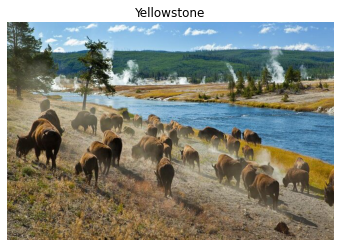

In [9]:
# show the image
plt.clf()
plt.axis('off')
plt.title('Yellowstone')
plt.imshow(img)
plt.show()

## Training Data

Turn the image into training data for our k-means algorithm.  We need to transform the 3D image structure into a 2D training dataset.

In [10]:
# transform 3D image structure to a 2D numpy array for training the k-means model
# by listing all pixels as a continuous list of color vectors

w, h, d = img.shape
assert d == 3

# the array is now a list of color values: list of points/pixels in RGB space.
pixel_array = np.reshape(img, (w * h, 3))
pixel_array[:16,]

array([[0.2745098 , 0.34509804, 0.25098039],
       [0.43529412, 0.50588235, 0.41960784],
       [0.38823529, 0.4627451 , 0.38823529],
       [0.19215686, 0.2745098 , 0.21568627],
       [0.36862745, 0.45490196, 0.40784314],
       [0.44705882, 0.52941176, 0.50980392],
       [0.54117647, 0.62745098, 0.61568627],
       [0.24313725, 0.32941176, 0.32156863],
       [0.18431373, 0.2627451 , 0.25882353],
       [0.28627451, 0.36470588, 0.35686275],
       [0.26666667, 0.32941176, 0.31764706],
       [0.16862745, 0.23137255, 0.19215686],
       [0.18823529, 0.23529412, 0.18823529],
       [0.31372549, 0.35686275, 0.29411765],
       [0.19215686, 0.22745098, 0.15294118],
       [0.2627451 , 0.29411765, 0.21176471]])

In [11]:
len(pixel_array)

298374

Our image has more than a quarter million pixels.  This is way too much data to train our k-means algorithm.  We sample the pixels to create our training data.

In [12]:

# Fitting k-means model on a 1% sub-sample of the data for speed reasons
assert(len(pixel_array) > 100)
pixel_array_sample = shuffle(pixel_array, random_state=0)[:len(pixel_array)//100]
pixel_array_hex = np.array([to_hex(pixel_array_sample[i]) for i in range(len(pixel_array_sample))])

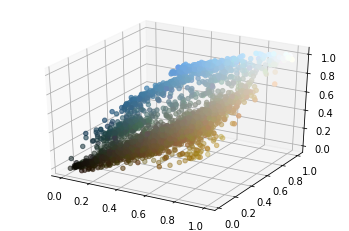

In [13]:
# plot the colors of training data - plot training RGB space
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pixel_array_sample[:,0], pixel_array_sample[:,1], pixel_array_sample[:,2],c=pixel_array_hex);
plt.show()

### Model Building

In [14]:
# train the model with n_colors
model = KMeans(n_clusters=n_colors, random_state=0)
model.fit(pixel_array_sample)

# the cluster centers now represent the new colors
compressed_colors = model.cluster_centers_
compressed_colors

array([[0.79859944, 0.85795518, 0.87128852],
       [0.57218907, 0.49569006, 0.35575763],
       [0.20028835, 0.18624567, 0.11883891],
       [0.53441069, 0.71879983, 0.86591252],
       [0.23130227, 0.35991285, 0.35777637],
       [0.34563107, 0.52975443, 0.64547877],
       [0.69179056, 0.6429972 , 0.54020685],
       [0.41637793, 0.35116636, 0.23186193]])

In [15]:
compressed_colors_hex = np.array([to_hex(compressed_colors[i]) for i in range(len(compressed_colors))])

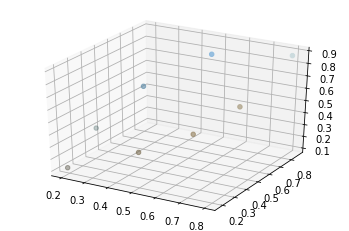

In [16]:
# plot the colors of the k-means model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(compressed_colors[:,0], compressed_colors[:,1], compressed_colors[:,2],c=compressed_colors_hex);
plt.show()

### Build Compressed Image

In [17]:
# map each pixel in the image into a color cluster
new_color_ix = model.predict(pixel_array)
# show a sample of the label/centroid ids
shuffle(new_color_ix)[:32]

array([3, 7, 5, 1, 1, 7, 0, 1, 4, 7, 4, 6, 7, 1, 1, 1, 4, 5, 5, 1, 4, 4,
       3, 7, 7, 6, 5, 0, 4, 2, 1, 7], dtype=int32)

In [18]:
# create a new pixel array based on the new colors
new_pixel_array = np.zeros((w*h,3))
for i in range(w*h):
    new_pixel_array[i] = compressed_colors[new_color_ix[i]]

# reshape the new pixel array into a new image with the same dimensions as the original image.
new_img = np.reshape(new_pixel_array,(w,h,3))

### Image Comparison

Not only do we show the original and the compressed image but we also save them to files so we can look at the effect that color quantization has on image file size.

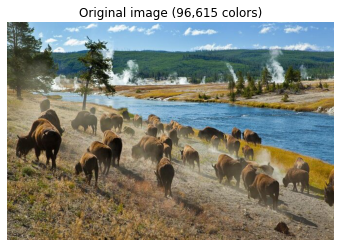

In [19]:
# original image
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(img)
plt.savefig("original.png")
plt.show()

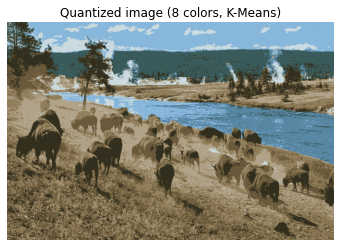

In [20]:
# quantized image
plt.clf()
plt.axis('off')
plt.title('Quantized image ({} colors, K-Means)'.format(n_colors))
plt.imshow(new_img)
plt.savefig("compressed.png")
plt.show()

The sizes of the files are shown in KBytes.

In [21]:
!ls -s -k original.png
!ls -s -k compressed.png

168 original.png
140 compressed.png
